In [1]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 220, 3.175e-3
delta_r = wavelength / 100

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

class tree:
    def __init__(self, its, phi, length, f, radius, field):
        self.its = its
        self.phi = phi
        self.length = length
        self.f = f
        self.radius = radius
        self.field = field

basis_functions = 'triangle'
structure_type = 'tree'
its = 2
phi = np.full(2 * (2 ** its - 1), np.pi/3)
length = wavelength/2
f = 1/np.sqrt(2)
radius = 3.175e-3
field = incident_field
tree_test = tree(its,phi,length,f,radius,field)

In [ ]:
I,R = solve.calc_current_amplitudes(structure_type, basis_functions, tree_test, frequency, delta_r)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
sc = plt.scatter(R[:,0], R[:,1], c=np.abs(I), cmap='plasma', s=20, marker='o')
plt.colorbar(sc, label='Ток (I)')
plt.xlabel('X')
plt.ylabel('Y') 
plt.title('Градиент тока в плоскости XY')
plt.axis('equal')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import geometry as gm
from scipy import linalg 
import scipy.integrate as integrate 
from tqdm import tqdm

c, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

def basis_func(basis_functions, t_n, r_n, dr_n):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_n <= 1/2 :
            return 1/2 + t_n
        elif 1/2 <= t_n <= 3/2 :
            return 3/2 - t_n

def weight_func(basis_functions, t_m, r_m, dr_m):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_m <= 1/2 :
            return 1/2 + t_m
        elif 1/2 <= t_m <= 3/2 :
            return 3/2 - t_m

def ReGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    rmn = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2))
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return f_n * f_m * np.cos(- k * rmn) / rmn
def ImGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    rmn = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2))
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return f_n * f_m * np.sin(- k * rmn) / rmn

def RederderXXGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R 
    p2R_px2 = 1/R - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px ** 2 + polypart2 * p2R_px2) * np.exp(-1j * k * R)).real  
def ImderderXXGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R 
    p2R_px2 = 1/R - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px ** 2 + polypart2 * p2R_px2) * np.exp(-1j * k * R)).imag

def RederderYYGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R 
    p2R_py2 = 1/R - (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_py ** 2 + polypart2 * p2R_py2) * np.exp(-1j * k * R)).real
def ImderderYYGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R 
    p2R_py2 = 1/R - (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_m * f_n * (polypart1 * pR_py ** 2 + polypart2 * p2R_py2) * np.exp(-1j * k * R)).imag

def RederderZZGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R 
    p2R_pz2 = 1/R - (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_pz ** 2 + polypart2 * p2R_pz2) * np.exp(-1j * k * R)).real
def ImderderZZGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R 
    p2R_pz2 = 1/R - (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_pz ** 2 + polypart2 * p2R_pz2) * np.exp(-1j * k * R)).imag

def RederderXYGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R 
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R
    p2R_pxy = - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) * (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px * pR_py + polypart2 * p2R_pxy) * np.exp(-1j * k * R)).real
def ImderderXYGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R 
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R
    p2R_pxy = - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) * (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px * pR_py + polypart2 * p2R_pxy) * np.exp(-1j * k * R)).imag

def RederderYZGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R
    p2R_pyz = - (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) * (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_py * pR_pz + polypart2 * p2R_pyz) * np.exp(-1j * k * R)).real
def ImderderYZGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R
    p2R_pyz = - (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) * (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_py * pR_pz + polypart2 * p2R_pyz) * np.exp(-1j * k * R)).imag

def RederderXZGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R
    p2R_pxz = - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) * (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px * pR_pz + polypart2 * p2R_pxz) * np.exp(-1j * k * R)).real
def ImderderXZGreen_function_single(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    t_n = 1/2
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R
    p2R_pxz = - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) * (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px * pR_pz + polypart2 * p2R_pxz) * np.exp(-1j * k * R)).imag


def Zmn_single (structure_type, basis_functions, m, n, i, j, segments_block, omega, delta_r):

    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
    
    a_m = segments_block[m][i].radius
    a_n = segments_block[n][j].radius
    
    tau_m = segments_block[m][i].tau
    tau_n = segments_block[n][j].tau
    
    r_m = segments_block[m][i].position
    r_n = segments_block[n][j].position

    if structure_type == 'tree':
        r_n = r_n + a_n * np.array([0,0,1])
    elif structure_type == 'yagi-uda':
        r_n = r_n + a_n * np.array([0,0,1])

    dr_m = delta_r * tau_m
    dr_n = delta_r * tau_n
    
    if np.abs(np.dot(tau_m, tau_n)) <= 1e-21:
        Z_0 = 0
    else:
        Z_0 = 1j*omega*mu0 / (4*np.pi) * np.dot(tau_m, tau_n) * delta_r**2 * (integrate.quad(ReGreen_function_single, t_min, t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(ImGreen_function_single, t_min, t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_m[0] * tau_m[0]) <= 1e-21:
        Z_xx = 0
    else:
        Z_xx = 1j/(4*np.pi * omega * eps0) * tau_m[0] * tau_n[0] * delta_r**2  * (integrate.quad(RederderXXGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(ImderderXXGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])

    if np.abs(tau_m[1] * tau_m[1]) <= 1e-21:
        Z_yy = 0
    else:
        Z_yy = 1j/(4*np.pi * omega * eps0) * tau_m[1] * tau_n[1] * delta_r**2  * (integrate.quad(RederderYYGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(ImderderYYGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_m[2] * tau_m[2]) <= 1e-21:
        Z_zz = 0
    else:
        Z_zz = 1j/(4*np.pi * omega * eps0) * tau_m[2] * tau_n[2] * delta_r**2  * (integrate.quad(RederderZZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(ImderderZZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_n[0] * tau_m[1] + tau_n[1] * tau_m[0])  <= 1e-21:
        Z_xy = 0
    else:
        Z_xy = 1j/(4*np.pi * omega * eps0) * (tau_n[0] * tau_m[1] + tau_n[1] * tau_m[0]) * delta_r**2  * (integrate.quad(RederderXYGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(ImderderXYGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_n[0] * tau_m[2] + tau_n[2] * tau_m[0]) <= 1e-21:
        Z_xz = 0
    else:
        Z_xz = 1j/(4*np.pi * omega * eps0) * (tau_n[0] * tau_m[2] + tau_n[2] * tau_m[0]) * delta_r**2  * (integrate.quad(RederderXZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(ImderderXZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_n[2] * tau_m[1] + tau_n[1] * tau_m[2]) <= 1e-21:
        Z_yz = 0
    else:
        Z_yz = 1j/(4*np.pi * omega * eps0) * (tau_n[2] * tau_m[1] + tau_n[1] * tau_m[2]) * delta_r**2  * (integrate.quad(RederderYZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(ImderderYZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    return Z_0 + Z_xx + Z_yy + Z_zz + Z_xy + Z_xz + Z_yz


def ReGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    rmn = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2))
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return f_n * f_m * np.cos(- k * rmn) / rmn
def ImGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    rmn = np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2))
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return f_n * f_m * np.sin(- k * rmn) / rmn

def RederderXXGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R 
    p2R_px2 = 1/R - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px ** 2 + polypart2 * p2R_px2) * np.exp(-1j * k * R)).real  
def ImderderXXGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R 
    p2R_px2 = 1/R - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px ** 2 + polypart2 * p2R_px2) * np.exp(-1j * k * R)).imag

def RederderYYGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R 
    p2R_py2 = 1/R - (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_py ** 2 + polypart2 * p2R_py2) * np.exp(-1j * k * R)).real
def ImderderYYGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R 
    p2R_py2 = 1/R - (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_m * f_n * (polypart1 * pR_py ** 2 + polypart2 * p2R_py2) * np.exp(-1j * k * R)).imag

def RederderZZGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R 
    p2R_pz2 = 1/R - (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_pz ** 2 + polypart2 * p2R_pz2) * np.exp(-1j * k * R)).real
def ImderderZZGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R 
    p2R_pz2 = 1/R - (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2))**2 / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3)
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_pz ** 2 + polypart2 * p2R_pz2) * np.exp(-1j * k * R)).imag

def RederderXYGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R 
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R
    p2R_pxy = - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) * (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px * pR_py + polypart2 * p2R_pxy) * np.exp(-1j * k * R)).real
def ImderderXYGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R 
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R
    p2R_pxy = - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) * (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px * pR_py + polypart2 * p2R_pxy) * np.exp(-1j * k * R)).imag

def RederderYZGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R
    p2R_pyz = - (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) * (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_py * pR_pz + polypart2 * p2R_pyz) * np.exp(-1j * k * R)).real
def ImderderYZGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_py = (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) / R
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R
    p2R_pyz = - (r_m[1] + dr_m[1] * (t_m - 1/2) - r_n[1] - dr_n[1] * (t_n - 1/2)) * (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_py * pR_pz + polypart2 * p2R_pyz) * np.exp(-1j * k * R)).imag

def RederderXZGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R
    p2R_pxz = - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) * (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px * pR_pz + polypart2 * p2R_pxz) * np.exp(-1j * k * R)).real
def ImderderXZGreen_function_double(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega/c
    R = np.linalg.norm(r_m + dr_m * (t_m - 1/2) - r_n - dr_n * (t_n - 1/2))
    pR_px = (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) / R
    pR_pz = (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R
    p2R_pxz = - (r_m[0] + dr_m[0] * (t_m - 1/2) - r_n[0] - dr_n[0] * (t_n - 1/2)) * (r_m[2] + dr_m[2] * (t_m - 1/2) - r_n[2] - dr_n[2] * (t_n - 1/2)) / R**3
    polypart1 = -(1j * k / R**2 - (1 + 1j * k * R) * 1j * k / R**2 - 2 * (1 + 1j * k * R) / R**3) 
    polypart2 = -(1 + 1j * k * R) / R**2
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    return (f_n * f_m * (polypart1 * pR_px * pR_pz + polypart2 * p2R_pxz) * np.exp(-1j * k * R)).imag


def Zmn_double (structure_type, basis_functions, m, n, i, j, segments_block, omega, delta_r):

    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
        
    a_m = segments_block[m][i].radius
    a_n = segments_block[n][j].radius
    
    tau_m = segments_block[m][i].tau
    tau_n = segments_block[n][j].tau
    
    r_m = segments_block[m][i].position
    r_n = segments_block[n][j].position
    
    if structure_type == 'yagi-uda':
        r_n = r_n + a_n * np.array([0,0,1])
    elif structure_type == 'tree':
        r_n = r_n + a_n * np.array([0,0,1])   
        
    dr_m = delta_r * tau_m
    dr_n = delta_r * tau_n
    
    if np.abs(np.dot(tau_m, tau_n)) <= 1e-21:
        Z_0 = 0
    else:
        Z_0 = 1j*omega*mu0 / (4*np.pi) * np.dot(tau_m, tau_n) * delta_r**2 * (integrate.dblquad(ReGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_m[0] * tau_n[0]) <= 1e-21:
        Z_xx = 0
    else:
        Z_xx = 1j/(4*np.pi * omega * eps0) * tau_m[0] * tau_n[0] * delta_r**2  * (integrate.dblquad(RederderXXGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderXXGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])

    if np.abs(tau_m[1] * tau_n[1]) <= 1e-21:
        Z_yy = 0
    else:
        Z_yy = 1j/(4*np.pi * omega * eps0) * tau_m[1] * tau_n[1] * delta_r**2  * (integrate.dblquad(RederderYYGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderYYGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_m[2] * tau_n[2]) <= 1e-21:
        Z_zz = 0
    else:
        Z_zz = 1j/(4*np.pi * omega * eps0) * tau_m[2] * tau_n[2] * delta_r**2  * (integrate.dblquad(RederderZZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderZZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_n[0] * tau_m[1] + tau_n[1] * tau_m[0]) <= 1e-21:
        Z_xy = 0
    else:
        Z_xy = 1j/(4*np.pi * omega * eps0) * (tau_n[0] * tau_m[1] + tau_n[1] * tau_m[0]) * delta_r**2  * (integrate.dblquad(RederderXYGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderXYGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_n[0] * tau_m[2] + tau_n[2] * tau_m[0]) <= 1e-21:
        Z_xz = 0
    else:
        Z_xz = 1j/(4*np.pi * omega * eps0) * (tau_n[0] * tau_m[2] + tau_n[2] * tau_m[0]) * delta_r**2  * (integrate.dblquad(RederderXZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderXZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_n[2] * tau_m[1] + tau_n[1] * tau_m[2]) <= 1e-21:
        Z_yz = 0
    else:
        Z_yz = 1j/(4*np.pi * omega * eps0) * (tau_n[2] * tau_m[1] + tau_n[1] * tau_m[2]) * delta_r**2  * (integrate.dblquad(RederderYZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderYZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    return (Z_0 + Z_xx + Z_yy + Z_zz + Z_xy + Z_xz + Z_yz)


def Zmn (structure_type, basis_functions, m, n, i, j, segments_block, omega, delta_r):

    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
        
    a_m = segments_block[m][i].radius
    a_n = segments_block[n][j]. radius
    
    tau_m = segments_block[m][i].tau
    tau_n = segments_block[n][j].tau
    
    r_m = segments_block[m][i].position 
    r_n = segments_block[n][j].position 
    
    if structure_type == 'yagi-uda':
        r_n = r_n + a_n * np.array([0,0,1])
    elif structure_type == 'tree':
        r_n = r_n + a_n * np.array([0,0,1])

    dr_m = delta_r * tau_m
    dr_n = delta_r * tau_n
    
    if np.abs(np.dot(tau_m, tau_n)) <= 1e-21:
        Z_0 = 0
    else:
        Z_0 = 1j*omega*mu0 / (4*np.pi) * np.dot(tau_m, tau_n) * delta_r**2 * (integrate.quad(ReGreen_function_single, t_min, t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_m[0] * tau_n[0]) <= 1e-21:
        Z_xx = 0
    else:
        Z_xx = 1j/(4*np.pi * omega * eps0) * tau_m[0] * tau_n[0] * delta_r**2  * (integrate.quad(RederderXXGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderXXGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_m[1] * tau_n[1]) <= 1e-21:
        Z_yy = 0
    else:
        Z_yy = 1j/(4*np.pi * omega * eps0) * tau_m[1] * tau_n[1] * delta_r**2  * (integrate.quad(RederderYYGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderYYGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_m[2] * tau_n[2]) <= 1e-21:
        Z_zz = 0
    else:
        Z_zz = 1j/(4*np.pi * omega * eps0) * tau_m[2] * tau_n[2] * delta_r**2  * (integrate.quad(RederderZZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderZZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs((tau_n[0] * tau_m[1] + tau_n[1] * tau_m[0])) <= 1e-21:
        Z_xy = 0
    else:
        Z_xy = 1j/(4*np.pi * omega * eps0) * (tau_n[0] * tau_m[1] + tau_n[1] * tau_m[0]) * delta_r**2  * (integrate.quad(RederderXYGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderXYGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_n[0] * tau_m[2] + tau_n[2] * tau_m[0]) <= 1e-21:
        Z_xz = 0
    else:
        Z_xz = 1j/(4*np.pi * omega * eps0) * (tau_n[0] * tau_m[2] + tau_n[2] * tau_m[0]) * delta_r**2  * (integrate.quad(RederderXZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderXZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    if np.abs(tau_n[2] * tau_m[1] + tau_n[1] * tau_m[2]) <= 1e-21:
        Z_yz = 0
    else:
        Z_yz = 1j/(4*np.pi * omega * eps0) * (tau_n[2] * tau_m[1] + tau_n[1] * tau_m[2]) * delta_r**2  * (integrate.quad(RederderYZGreen_function_single, t_min, t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(ImderderYZGreen_function_double, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args = (r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])
    
    return (Z_0 + Z_xx + Z_yy + Z_zz + Z_xy + Z_xz + Z_yz)


def calculate_impedance (basis_functions, structure_type, segments_block, frequency, delta_r):
    
    omega = 2 * np.pi * frequency
    
    element_num = []
    for i in range (len(segments_block)):
        element_num.append(len(segments_block[i]))
    element_num = np.array(element_num)
    
    impedance_block = []
    
    if structure_type == 'yagi-uda':    
        for m in range(len(segments_block)):
            impedance_row = []
            for n in range(len(segments_block)):
                impedance_mn = np.zeros((len(segments_block[m]), len(segments_block[n])), dtype=complex)
                if m <= n :
                    for i in range (len(segments_block[m]) + len(segments_block[n])):
                        impedance_mn[max(0, len(segments_block[m])-i-1), max(0, i-len(segments_block[m]))] = Zmn_double(structure_type=structure_type,basis_functions=basis_functions, m=m, n=n, i=max(0, len(segments_block[m])-i-1), j=max(0, i-len(segments_block[m])), segments_block=segments_block, omega=2*np.pi*frequency, delta_r=delta_r)
                        for k in range (min( min(len(segments_block[m]), len(segments_block[n])), i+1, len(segments_block[m]) + len(segments_block[n]) - i)):
                            impedance_mn[max(0, len(segments_block[m])-i-1) + k, max(0, i-len(segments_block[m])) + k] = impedance_mn[max(0, len(segments_block[m])-i-1), max(0, i-len(segments_block[m]))]
                else :
                    impedance_mn = impedance_block[n][m].T
                impedance_row.append(impedance_mn)   
            impedance_block.append(impedance_row)
    
    elif structure_type == 'tree':
        for m in range(len(segments_block)):
            impedance_row = []
            for n in range(len(segments_block)):
                impedance_mn = np.zeros((len(segments_block[m]), len(segments_block[n])), dtype=complex)
                if m <= n :
                    for i in range(len(segments_block[m])):
                        for j in range(len(segments_block[n])):
                            impedance_mn[i,j] = Zmn_single(structure_type,basis_functions,m,n,i,j,segments_block,omega,delta_r)
                else :
                    impedance_mn = impedance_block[n][m].T
                impedance_row.append(impedance_mn)
            impedance_block.append(impedance_row)
    
    num_elements = sum(element_num)
    impedance = np.zeros((num_elements, num_elements), dtype = complex)
    cum_n = np.append(0, np.cumsum(element_num))
    for i in range (len(cum_n)-1):
        for j in range (len(cum_n)-1):
            impedance[cum_n[i]:cum_n[i+1], cum_n[j]:cum_n[j+1]] = impedance_block[i][j]
    
    return impedance

segments_block, souce_segments = gm.antenna_to_segments(structure_type, tree_test, basis_functions, delta_r)
r0 = segments_block[0][0].position

Z_double, Z_single, distance = [], [], []
for m in range(len(segments_block)):
    for i in tqdm(range(len(segments_block[m]))):
        distance.append(np.linalg.norm(r0 - segments_block[m][i].position))
        Z_double.append(Zmn_double(structure_type, basis_functions, 0,m,0,i,segments_block,omega,delta_r))
        Z_single.append(Zmn_single(structure_type, basis_functions, 0,m,0,i,segments_block,omega,delta_r))
        
distance = np.array(distance)
Z_double = np.array(Z_double)
Z_single = np.array(Z_single)

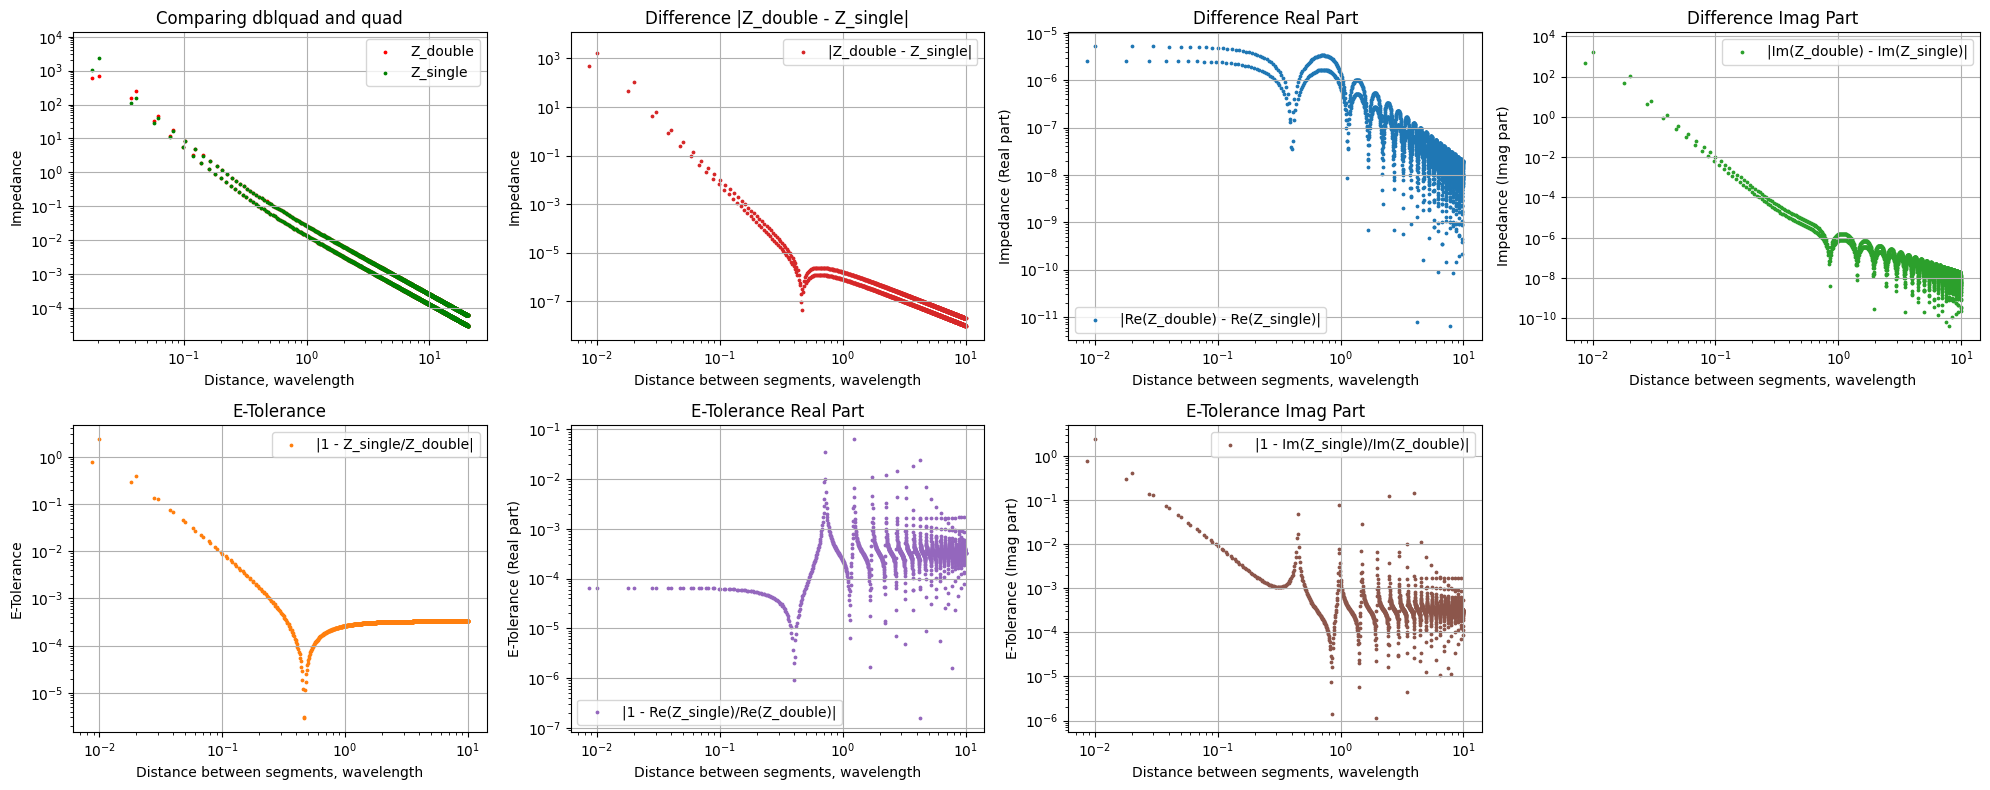

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink']

axs[0].scatter(distance, np.abs(Z_double), s=3, color='red', label='Z_double')
axs[0].scatter(distance, np.abs(Z_single), s=3, color='green', label='Z_single')
axs[0].set_title('Comparing dblquad and quad')
axs[0].set_xlabel('Distance, wavelength')
axs[0].set_ylabel('Impedance')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid()
axs[0].legend()

axs[1].scatter(distance / wavelength, np.abs(np.abs(Z_double) - np.abs(Z_single)), color=colors[0], s=3, label='|Z_double - Z_single|')
axs[1].set_title('Difference |Z_double - Z_single|')
axs[1].set_xlabel('Distance between segments, wavelength')
axs[1].set_ylabel('Impedance')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid()
axs[1].legend()

axs[2].scatter(distance / wavelength, np.abs(np.abs(Z_double.real) - np.abs(Z_single.real)), color=colors[1], s=3, label='|Re(Z_double) - Re(Z_single)|')
axs[2].set_title('Difference Real Part')
axs[2].set_xlabel('Distance between segments, wavelength')
axs[2].set_ylabel('Impedance (Real part)')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].grid()
axs[2].legend()

axs[3].scatter(distance / wavelength, np.abs(np.abs(Z_double.imag) - np.abs(Z_single.imag)), color=colors[2], s=3, label='|Im(Z_double) - Im(Z_single)|')
axs[3].set_title('Difference Imag Part')
axs[3].set_xlabel('Distance between segments, wavelength')
axs[3].set_ylabel('Impedance (Imag part)')
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].grid()
axs[3].legend()

axs[4].scatter(distance / wavelength, np.abs(1 - np.abs(Z_single)/np.abs(Z_double)), color=colors[3], s=3, label='|1 - Z_single/Z_double|')
axs[4].set_title('E-Tolerance')
axs[4].set_xlabel('Distance between segments, wavelength')
axs[4].set_ylabel('E-Tolerance')
axs[4].set_xscale('log')
axs[4].set_yscale('log')
axs[4].grid()
axs[4].legend()

axs[5].scatter(distance / wavelength, np.abs(1 - np.abs(Z_single.real)/np.abs(Z_double.real)), color=colors[4], s=3, label='|1 - Re(Z_single)/Re(Z_double)|')
axs[5].set_title('E-Tolerance Real Part')
axs[5].set_xlabel('Distance between segments, wavelength')
axs[5].set_ylabel('E-Tolerance (Real part)')
axs[5].set_xscale('log')
axs[5].set_yscale('log')
axs[5].grid()
axs[5].legend()

axs[6].scatter(distance / wavelength, np.abs(1 - np.abs(Z_single.imag)/np.abs(Z_double.imag)), color=colors[5], s=3, label='|1 - Im(Z_single)/Im(Z_double)|')
axs[6].set_title('E-Tolerance Imag Part')
axs[6].set_xlabel('Distance between segments, wavelength')
axs[6].set_ylabel('E-Tolerance (Imag part)')
axs[6].set_xscale('log')
axs[6].set_yscale('log')
axs[6].grid()
axs[6].legend()

axs[7].axis('off')

plt.tight_layout()
plt.show()